# QMCPy data compression for Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/qmc_ml_compression.ipynb)

We have created a reimplementation of a data compression algorithm that compresses large datasets using digital nets.  
This reproduces the algorithm found in

[Dick, Josef, and Michael Feischl. "A quasi-Monte Carlo data compression algorithm
for machine learning." Journal of Complexity 67 (2021): 101587.](https://www.sciencedirect.com/science/article/abs/pii/S0885064X2100042X)


Below we illustrate that implementation by reproducing Figure 3 in the paper pertaining to linear regression:


In [1]:
from pathlib import Path #N.B using Path to use a better api and easier reasonsing about path.
import numpy as np
import matplotlib.pyplot as plt
from qmcpy import DigitalNetDataCompressor

Numpy is used here for its ability to represent matricies and to allow us to perform the mathematical operations to reproduce the algorithm. Matplotlib is used plot the results to compare the linear regression found at the end. Our reproduction of the results which can be found in the DigitalNetCompression class which interfaces C code using the [ctypes class](https://docs.python.org/3/library/ctypes.html). 

The following is the equation we will implement in numpy.

\begin{align*}
 f_\theta(x) = (1,x)\theta
\end{align*}

In [2]:
# linear regression function
def f(x, w):
    return np.hstack((np.ones((x.shape[0], 1)), x)) @ w

Below is where we call the DigitalNetCompressor class with the following arguments that it computes the weights given the dataset's labels , points, shape, the hyperparameters.

* $\alpha$ Order of the sobol sequence
*  $\nu$ #TODO
* $\mu$ #TODO
* A dat file of the sobol sequence. Note while the data is compressed we compute the weights at each iteration

What is returned is the of weights: first column is $W_X$ and second column is $W_{X,Y}$


In [3]:
def data_compress_lin_reg(x, labels, mmax=5, nsample=100, alpha=1):
    # dimension of data
    d = x.shape[1]
    t = 4
    # aux parameters
    err_vec = np.zeros((mmax, nsample))

    p = Path('../workouts/digital_net_compressor/sobol2.dat') #Using relative path from workouts (large file)
    # loop to plot the approximation error
    for m in range(mmax):
        # compute weights for approximation formula
        dn = DigitalNetDataCompressor(nu=m + 1, 
                                      m=int(np.ceil((1 + 1.0 / alpha) * (m + 1) + t)), 
                                      dataset=x,
                                      labels=labels,
                                      alpha=alpha,
                                      sobol=np.loadtxt(p))
        dn.approx_mean_mxy()
        weights, z = dn.weights, dn.sobol

        # compute exact error for random linear regression functions
        w = np.random.randn(d + 1, nsample)
        mval = np.mean((f(x, w) - labels.reshape(-1, 1)) ** 2, axis=0)

        # compute approximation
        fz = f(z, w)
        mvalapprox = (weights[:, 0].reshape(-1, 1) * (fz ** 2)).sum(axis=0) - 2 * (
                weights[:, 1].reshape(-1, 1) * fz).sum(axis=0) + np.mean(labels ** 2)

        # compute relative error
        err_vec[m, :] = np.abs(mvalapprox - mval) / np.abs(mval)

    # compute errors vs cost_vec
    cost_vec = 2 ** np.ceil((1.0 / alpha + 1) * np.array(range(1, mmax + 1)))

    return cost_vec, err_vec

We will create random data using a pseudorandom source (merseene twister) and create a label vector of the same cardinality to compress the data so we can reproduce the results.

In [4]:
# set up random data
N = int(1e4)  # 1e6
np.random.seed(2) #Uncomment this out to make it deterministic. 
#This will fix the seed of the random number generator.
x = np.abs(np.random.randn(N, 5))
x = x / (1.01 * np.amax(x, axis=0))
labels = np.random.rand(N, 1).reshape(-1)
alpha_vec = [1]  # [1, 2]
mmax_vec = [5]  # [5, 7]

Using matplotlib we will reproduce the diagrams found in the paper. We compute the cost of the algorithm with the error of the data compression algorithm compared with the uncompress cost.

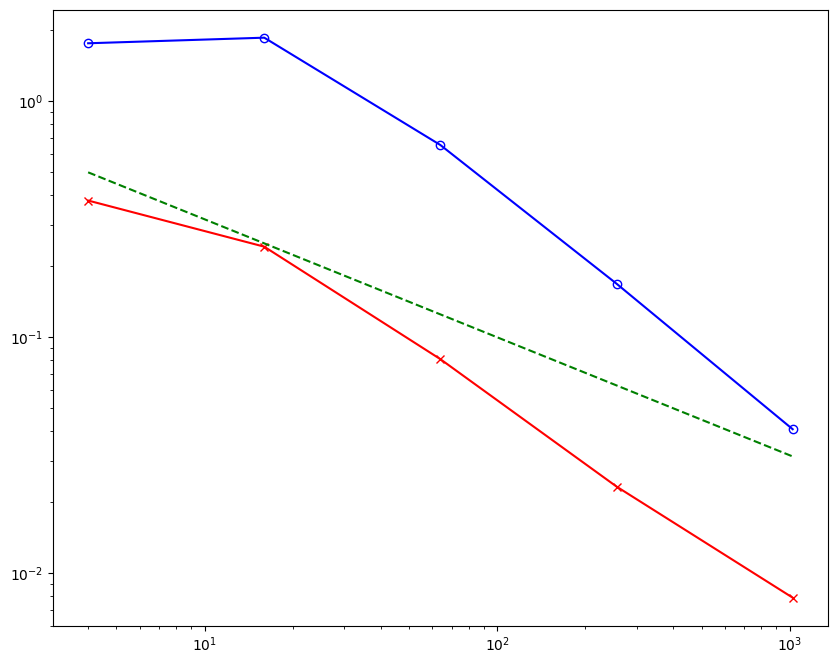

In [5]:
plt.figure(figsize=(10, 8))
for alpha, mmax in zip(alpha_vec, mmax_vec):
    cost, errvec = data_compress_lin_reg(x, labels, mmax=mmax, alpha=alpha)
    if alpha == 1:
        marker1, marker2, marker3 = '-ob', '-xr', '--g'
    elif alpha == 2:
        marker1, marker2, marker3 = '-dy', '-sm', '--k'
    plt.loglog(cost, np.amax(errvec, axis=1), marker1, markerfacecolor='none',
               label=r"$\alpha$ = " + str(alpha) + ", maximum")
    plt.loglog(cost, np.mean(errvec, axis=1), marker2, markerfacecolor='none',
               label=r"$\alpha$ = " + str(alpha) + ", average")
    plt.loglog(cost, 1 / cost ** (1.0 / (1 + 1 / alpha)), marker3,
               label=r"$\alpha$ = " + str(alpha) + ", predicted convergence order")

Now we will generate the plot using the computations above.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


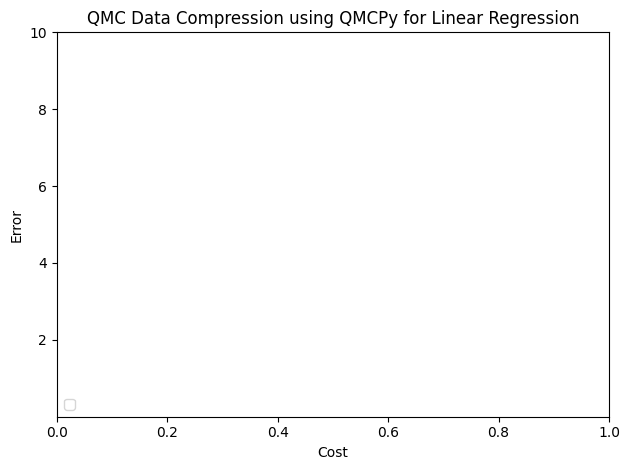

In [6]:
plt.xlabel("Cost")
plt.ylabel("Error") 
plt.ylim(1e-3, 10)  # set labels-axis limits
plt.legend(loc='lower left')  # bbox_to_anchor=(1, 0.5))  # display the legends
plt.title("QMC Data Compression using QMCPy for Linear Regression")
plt.tight_layout()
plt.show(block=False)